## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping

In [2]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!mv fra-eng.zip data/fra-eng.zip
!!unzip -o data/fra-eng.zip -d data

['Archive:  data/fra-eng.zip',
 '  inflating: data/_about.txt         ',
 '  inflating: data/fra.txt            ']

In [3]:
batch_size = 64      # Batch size for training.
epochs = 100         # Number of epochs to train for.
latent_dim = 256     # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

# Path to the data txt file on disk.
data_path = "data/fra.txt"

## Data prep

In [4]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [5]:
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[:5]:
    print(line)
print("Number of lines: ", len(lines))

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)
Number of lines:  185584


In [6]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [7]:
print("input_texts ", len(input_texts))
print("target_texts", len(target_texts))
print("input_characters", len(input_characters))
print("target_characters", len(target_characters))

input_texts  10000
target_texts 10000
input_characters 71
target_characters 93


In [8]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [9]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
print("input_token_index", len(input_token_index))
print("target_token_index", len(target_token_index))

input_token_index 71
target_token_index 93


In [10]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
print("encoder_input_data.shape", encoder_input_data.shape)
print("decoder_input_data.shape", decoder_input_data.shape)
print("decoder_target_data.shape", decoder_target_data.shape)

encoder_input_data.shape (10000, 15, 71)
decoder_input_data.shape (10000, 59, 93)
decoder_target_data.shape (10000, 59, 93)


In [11]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    
    for t, char in enumerate(target_text):
        
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
            
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0
    

## Construct model

In [12]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape = (None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape = (None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11784492424940117722
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7620518240
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9072037145702411861
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7775883104
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 7559528275057294042
physical_device_desc: "device: 1, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Train model

In [15]:
model.compile(
    optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)

log = model.fit(
    [ encoder_input_data, decoder_input_data ],
    decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ es ],
    validation_split = 0.2,
)

Epoch 1/100
125/125 [==============================] - 4s 15ms/step - loss: 1.4802 - accuracy: 0.7059 - val_loss: 1.0734 - val_accuracy: 0.7099
Epoch 2/100
125/125 [==============================] - 2s 12ms/step - loss: 0.8645 - accuracy: 0.7661 - val_loss: 0.8180 - val_accuracy: 0.7717
Epoch 3/100
125/125 [==============================] - 2s 12ms/step - loss: 0.6971 - accuracy: 0.8064 - val_loss: 0.6937 - val_accuracy: 0.7998
Epoch 4/100
125/125 [==============================] - 2s 12ms/step - loss: 0.5839 - accuracy: 0.8309 - val_loss: 0.6336 - val_accuracy: 0.8145
Epoch 5/100
125/125 [==============================] - 2s 15ms/step - loss: 0.5330 - accuracy: 0.8449 - val_loss: 0.5904 - val_accuracy: 0.8259
Epoch 6/100
125/125 [==============================] - 2s 16ms/step - loss: 0.4981 - accuracy: 0.8542 - val_loss: 0.5657 - val_accuracy: 0.8352
Epoch 7/100
125/125 [==============================] - 2s 16ms/step - loss: 0.4717 - accuracy: 0.8606 - val_loss: 0.5421 - val_accuracy:

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

# Save model
model.save("s2s")

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


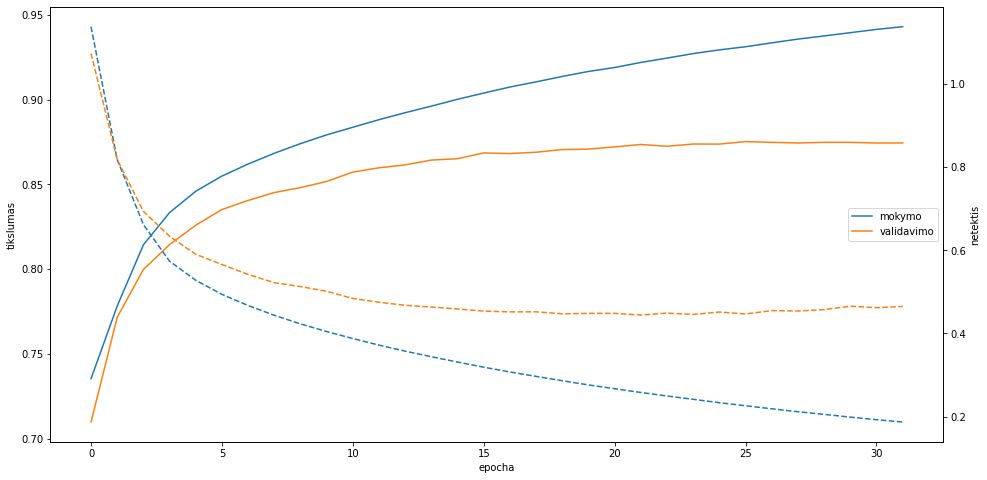

In [17]:
plt.plot(log.history['accuracy'], label = 'mokymo')
plt.plot(log.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend(loc='right') #['mokymo', 'testavimo'])

ax2 = plt.twinx()
ax2.plot(log.history['loss'], '--', label = 'mokymo')
ax2.plot(log.history['val_loss'], '--', label = 'validavimo')
ax2.set_ylabel('netektis')
#plt.title('model accuracy')
plt.show()

## Inference

In [18]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

In [19]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [20]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [21]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Poursuis !

-
Input sentence: Go.
Decoded sentence: Poursuis !

-
Input sentence: Go.
Decoded sentence: Poursuis !

-
Input sentence: Hi.
Decoded sentence: Attends-toi.

-
Input sentence: Hi.
Decoded sentence: Attends-toi.

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run!
Decoded sentence: Fais !

-
Input sentence: Run.
Decoded sentence: Fais stant !

-
Input sentence: Run.
Decoded sentence: Fais stant !

-
Input sentence: Run.
Decoded sentence: Fais stant !

-
Input sentence: Run.
Decoded sentence: Fais stant !

-
Input sentence: Run.
Decoded sentence: Fais stant !

-
Input sentence: Run.
Decoded sentence: Fais stant !

-
Input senten